In [47]:
# Reset repo
!git reset
!git clean -fd
!docker stop $(docker ps -a -q)

Unstaged changes after reset:
M	.gitignore
D	mlflow/MLProject
M	simple.ipynb
Removing .dvc/
Removing BASEDIR/
Removing MLProject
Removing dvc_out/
Removing dvc_simple.py
Removing mlflow/mlflow_out/
Removing mlflow_out/
Removing sacred_out/
Removing sacred_simple.py
Removing sacred_simple2.py
Removing simple.dvc
88ae3c58d002
5e9715598ec0
386beafc7d99


# Installation

To keep things clean and not run into version conflicts its recommended to setup a new anaconda environment with this command:

In [45]:
# Created with conda env export > environment.yml
!conda env create -f environment.yml


CondaValueError: prefix already exists: /Users/nkreiling/miniconda3/envs/data-version-control



If you just use an existing python environment, you can also easily install all three via pip

In [46]:
! pip install mlflow
! pip install dvc
! pip install sacred

# Preperations

Import the libraries we need (this is actually the default import I load via jupyter-magic commands every time I start something new)

In [3]:
# %load ~/dev/imports.py
import os
from datetime import datetime as dt

import numpy as np
import pandas as pd
import sklearn as skl

# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 10)

import IPython.display as ipd

# Set random seed 
RSEED = 42

# Visualizations
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25, 5)
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)


I created some helper functions we will need, but since they do not support the understanding of the frameworks we want to learn about, I excluded them into an own python file. Feels free to check them out, if you want to dig deeper.

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from utils import *

# Baseline Setup

We will use the boston housing prices dataset which can be received directly from scikit-learn

In [7]:
from sklearn.datasets import load_boston
boston = load_boston()

data = pd.DataFrame(boston.data,columns=boston.feature_names)
data['target'] = pd.Series(boston.target)
data.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
153,2.149,0.000,19.580,0.000,0.871,5.709,98.500,1.623,5.000,403.000,14.700,261.950,15.790,19.400
98,0.082,0.000,2.890,0.000,0.445,7.820,36.900,3.495,2.000,276.000,18.000,393.530,3.570,43.800
458,7.752,0.000,18.100,0.000,0.713,6.301,83.700,2.783,24.000,666.000,20.200,272.210,16.230,14.900
272,0.115,20.000,6.960,0.000,0.464,6.538,58.700,3.917,3.000,223.000,18.600,394.960,7.730,24.400
157,1.224,0.000,19.580,0.000,0.605,6.943,97.400,1.877,5.000,403.000,14.700,363.430,4.590,41.300


And this is the basic code we would use, if we do not want to track any information

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 

# Do a train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=10, random_state=42)

# Create and fit regression
linreg = LinearRegression()
linreg.fit(x_train, y_train)

# Do prediction and calculate mean absolute error
test_pred = linreg.predict(x_test)
mean_absolute_error(y_test, test_pred)

2.4968624733238176

# Sacred

Since we want to use some visualization, we will first start a database as storage backend and a visualzation tool using docker

In [9]:
%%bash 
docker run -d --rm -p 27017:27017 --name mongodb mongo
docker run -d --rm -p 9000:9000 --name omniboard --link mongodb:mongo vivekratnavel/omniboard -m mongo:27017:sacred
echo "wait a few seconds till containers are up"
sleep 10

5e9715598ec0beff291e0de9ef47d8d953e481776d5eaad735940009d2f05ceb
88ae3c58d0028fffd10b3dd0178df2f57707554dda4ffa292b61854a049123df
wait a few seconds till containers are up


In [10]:
!open http://127.0.0.1:9000/

### v1 (the more explicit version)

In [45]:
%%writefile sacred_simple.py
#!/usr/bin/env python

from __future__ import division, print_function, unicode_literals
from sacred import Experiment

ex = Experiment('Boston Housing Prices')
from utils import *
        
@ex.capture
def capturestuff(_seed):
    print(_seed)    

def cfg():
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "alpha" : 0.5,
        "min_child_samples" : 10,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.5,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 10
    }
    return params
    
def logSacred(run,model,data,param=dict(),metrics=dict(),features=None, tags=dict()):
    # Imports
    from sklearn.externals import joblib
    
    # Get some general information
    output_folder = "sacred_out"
    type = model.__module__.split(".")[0]
    modelname = model.__class__.__name__
    
    # Track config
    mycfg=cfg()
    ex.add_config(cfg_or_file=mycfg)
    
    # Track dependencies
    import pkg_resources
    for d in pkg_resources.working_set:
        ex.add_package_dependency(d.project_name,d.version)
    
    # Track source code
    data.to_csv("{}/data".format(output_folder))
    ex.add_resource("{}/data".format(output_folder))
    
    # Create file about features
    if features is not None:
        with open("{}/features.txt".format(output_folder), "w+") as f: 
            f.write(",".join(features))
        ex.add_artifact("{}/features.txt".format(output_folder))
        
    # plot Feature importances if avaible
    if plotFeatureImportances(model, features, type):
        ex.add_artifact("{}/featureimportance.png".format(output_folder))

    # Track Model binary
    if type=="sklearn":
        _ = joblib.dump(model,"{}/sklearn".format(output_folder))
        ex.add_artifact("{}/sklearn".format(output_folder))
    if type=="lgb":
        model.save_model("{}/lghtgbm.txt".format(output_folder))
        ex.add_artifact("{}/lghtgbm.txt".format(output_folder))
        
    # Log metrics
    for k,v in metrics.items():
        ex.log_scalar(k,v)
        
    # Tags can only be set using the UI

@ex.automain
def run(_run):
    """
    f a nice greet message.

    Uses the name from config.
    """
    # Setup
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_absolute_error 

    # Do a train_test_split on my Data
    data = getData()
    x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=10, random_state=42)
    
    # Define my params
    params=dict(alpha=0.5)
    
    clf = Lasso(**params)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    metrics = eval_metrics(y_test, predictions)
        
    logSacred(_run,clf,data,param=params,metrics=metrics,features=x_test.columns.values)

Overwriting sacred_simple.py


In [46]:
!mkdir -p sacred_out
!python sacred_simple.py -m sacred

INFO - Boston Housing Prices - Running command 'run'
INFO - Boston Housing Prices - Started run with ID "7"
/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
INFO - Boston Housing Prices - Completed after 0:00:01


### v2 (the more sacred-style ways)

In [41]:
%%writefile sacred_simple2.py
#!/usr/bin/env python
from __future__ import division, print_function, unicode_literals
from sacred import Experiment

# Imports need to be done in the beginning of the file, since sacred won't recognize them, if they occur within a function
from sklearn.externals import joblib

ex = Experiment('Boston Housing Prices')
from utils import *
        
@ex.capture
def capturestuff(_seed):
    print(_seed)

def getData():
    from sklearn.datasets import load_boston
    boston = load_boston()

    data = pd.DataFrame(boston.data,columns=boston.feature_names)
    data['target'] = pd.Series(boston.target)
    return data

@ex.config
def cfg(_log):
    alpha= 0.5
    
def logSacred(run,model,data,output_folder="sacred_out", param=dict(),metrics=dict(),features=None, tags=dict()):
    # Get some general information
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    type = model.__module__.split(".")[0]
    modelname = model.__class__.__name__
    
    # Config will be tracked automatically
    
    # Dependencies will also be tracked automatically
    
    # Track source code
    data.to_csv("{}/data".format(output_folder))
    #ex.add_source_file("{}/data".format(output_folder))
    ab = ex.open_resource("{}/data".format(output_folder))
    # Create file about features
    if features is not None:
        with open("{}/features.txt".format(output_folder), "w+") as f: 
            f.write(",".join(features))
        ex.add_artifact("{}/features.txt".format(output_folder))
        
    # plot Feature importances if avaible
    if plotFeatureImportances(model, features, type):
        ex.add_artifact("{}/featureimportance.png".format(output_folder))

    # Track Model binary
    if type=="sklearn":
        _ = joblib.dump(model,"{}/sklearn".format(output_folder))
        ex.add_artifact("{}/sklearn".format(output_folder))
    if type=="lgb":
        model.save_model("{}/lghtgbm.txt".format(output_folder))
        ex.add_artifact("{}/lghtgbm.txt".format(output_folder))
        
    # Log metrics
    for k,v in metrics.items():
        ex.log_scalar(k,v)
        
    # Set some tags to identify the experiment
    for tag, v in tags.items():
        ex.add.set_tag(t,v)

@ex.automain
def run(_run, alpha):
    # Setup
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import Lasso
    from sklearn.metrics import mean_absolute_error 

    # Do a train_test_split on my Data
    data = getData()
    x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=10, random_state=42)
    
    # Define my params
    params=dict(alpha=alpha)
    
    clf = Lasso(**params)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    metrics = eval_metrics(y_test, predictions)
        
    logSacred(_run,clf,data,param=params,metrics=metrics,features=x_test.columns.values)

Overwriting sacred_simple2.py


Let's run the script

In [42]:
!mkdir -p sacred_out
!python sacred_simple2.py -m sacred

/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
INFO - Boston Housing Prices - Running command 'run'
INFO - Boston Housing Prices - Started run with ID "4"
INFO - Boston Housing Prices - Completed after 0:00:01


And provide some additional parameters to it

In [14]:
!python sacred_simple2.py -m sacred with 'alpha=0.2'

/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
INFO - Boston Housing Prices - Running command 'run'
INFO - Boston Housing Prices - Started run with ID "2"
sklearn
WARNING - Boston Housing Prices - An error ocurred in the '<sacred.observers.mongo.MongoObserver object at 0xa21745ac8>' observer: [Errno 21] Is a directory: '/Users/nkreiling/playground/data-version-control/data'
ERROR - Boston Housing Prices - Failed after 0:00:00!
WARNING - Boston Housing Prices - The observer '<sacred.observers.mongo.MongoObserver object at 0xa21745ac8>' failed at some point during the run.
Exception originated from within Sacred.
Traceback (most recent calls):
  File "/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sacred/run.py", line 

Sacred also offers some functions to print configurations or list dependencies it detected

In [15]:
!python sacred_simple2.py print_config 

/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
INFO - Boston Housing Prices - Running command 'print_config'
INFO - Boston Housing Prices - Started
Configuration (modified, added, typechanged, doc):
  alpha = 0.5
  seed = 677426671                   # the random seed for this experiment
INFO - Boston Housing Prices - Completed after 0:00:00


In [16]:
!python sacred_simple2.py print_dependencies

/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
INFO - Boston Housing Prices - Running command 'print_dependencies'
INFO - Boston Housing Prices - Started
Dependencies:
  numpy                == 1.15.4
  sacred               == 0.7.4
  scikit-learn         == 0.20.0

Sources:
  sacred_simple2.py                            6600c191f2109d415821aa27be71bda0

Version Control:
M git@github.com:inovex/machine-learning-model-management.git  dfeeb3c68794b1edd72d722e61b8d9140eb80ca4

INFO - Boston Housing Prices - Completed after 0:00:00


You can easily switch the storage backend between runs using --file_storage handler

In [17]:
!python sacred_simple.py --file_storage=BASEDIR

INFO - Boston Housing Prices - Running command 'run'
INFO - Boston Housing Prices - Started run with ID "1"
/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
zc.lockfile 1.3.0
wrapt 1.10.11
wheel 0.32.2
Werkzeug 0.14.1
webencodings 0.5.1
wcwidth 0.1.7
urllib3 1.24.1
traitlets 4.3.2
tornado 5.1.1
testpath 0.4.2
terminado 0.8.1
tabulate 0.8.2
statsmodels 0.9.0
smmap2 2.0.5
six 1.11.0
simplejson 3.16.0
setuptools 40.5.0
Send2Trash 1.5.0
seaborn 0.9.0
scipy 1.1.0
scikit-learn 0.20.0
schema 0.6.8
sacred 0.7.4
s3transfer 0.1.13
requests 2.20.1
querystring-parser 1.2.3
pyzmq 17.1.2
PyYAML 3.13
pytz 2018.7
python-dateutil 2.7.5
pyrsistent 0.14.5
pyparsing 2.3.0
pymongo 3.7.2
Pygments 2.2.0
pyfiglet 0.7.6
pyasn1 0.4.4
py-cpuinfo 4.0.0
ptyprocess 0.6.0
protobuf 3.

# DVC

DVC works much like git, so we will first need to init the project

## Init

In [18]:
! dvc init

Adding '.dvc/state' to '.dvc/.gitignore'.
Adding '.dvc/lock' to '.dvc/.gitignore'.
Adding '.dvc/config.local' to '.dvc/.gitignore'.
Adding '.dvc/updater' to '.dvc/.gitignore'.
Adding '.dvc/state-journal' to '.dvc/.gitignore'.
Adding '.dvc/state-wal' to '.dvc/.gitignore'.
Adding '.dvc/cache' to '.dvc/.gitignore'.
Checking for updates...
You can now commit the changes to git.


DVC creates a .dvc folder that stores all important information and can be tracked using git (just as mentioned above)

In [19]:
! git status

On branch master
Your branch is up-to-date with 'origin/master'.
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   .dvc/.gitignore
	new file:   .dvc/config

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   .gitignore
	modified:   simple.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	BASEDIR/
	sacred_out/
	sacred_simple.py
	sacred_simple2.py



In [20]:
%%bash
# To re-run the command above, remove the dvc file  as well as the .dvc folder
#rm -rf .dvc
#rm simple.dvc

DVC does not provide a python api but gets controlled using the command line and scripts executes. Therefore we use the jupyter %writefile magic to create the file for our training

In [21]:
%%writefile dvc_simple.py
def logDVC(model,output_folder="dvc_out", param=dict(),metrics=dict(),features=None, tags=dict()):
    import json
    from sklearn.externals import joblib
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Get some general information
    type = model.__module__.split(".")[0]

    # No option to set some tags to identify the experiment

    # Save Model
    if type=="sklearn":
        _ = joblib.dump(model,"{}/mymodel".format(output_folder))
    if type=="lgb":
        model.save_model("{}/mymodel".format(output_folder))

    # Log metrics
    with open('{}/metrics.txt'.format(output_folder), 'w') as f:
        f.write(json.dumps(metrics))

    # plot Feature importances if avaible
    plotFeatureImportances(model, features, type)

    # Create file about features
    if features is not None:
        with open("{}/features.txt".format(output_folder), "w+") as f: 
            f.write(",".join(features))
            
if __name__ == "__main__":
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import Lasso
    # We need to import utils here, since it is an own script and the execution environment has no access to the jupyter execution environment
    from utils import *

    # Do a train_test_split
    data = getData()
    x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=10, random_state=42)

    # Define the details of our run
    params=dict(alpha=0.4)
    clf = Lasso(**params)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)

    metrics = eval_metrics(y_test, predictions)
    logDVC(clf,param=params,metrics=metrics,features=x_test.columns.values)

Writing dvc_simple.py


Now we can run the command using DVC. Since it will need a couple of information, its help fucntion is an important reference

In [22]:
!dvc run --help

usage: dvc run [-h] [-q | -v] [-d DEPS] [-o OUTS] [-O OUTS_NO_CACHE]
               [-M METRICS_NO_CACHE] [-f FILE] [-c CWD] [--no-exec] [-y]
               ...

Generate a stage file from a given command and execute the command.

positional arguments:
  command               Command or command file to execute.

optional arguments:
  -h, --help            show this help message and exit
  -q, --quiet           Be quiet.
  -v, --verbose         Be verbose.
  -d DEPS, --deps DEPS  Declare dependencies for reproducible cmd.
  -o OUTS, --outs OUTS  Declare output data file or data directory.
  -O OUTS_NO_CACHE, --outs-no-cache OUTS_NO_CACHE
                        Declare output regular file or directory (sync to Git,
                        not DVC cache).
  -M METRICS_NO_CACHE, --metrics-no-cache METRICS_NO_CACHE
                        Declare output metric file or directory (not cached by
                        DVC).
  -f FILE, --file FILE  Specify name of the stage file. It should be

We tell DVC which file to run (-d), the project file that keeps the information (-f), the metrics (-M) and the output file (-o).

In [23]:
%%bash
echo $(pwd)
dvc run  \
  -d dvc_simple.py \
  -f simple.dvc \
  -o dvc_count
  python dvc_simple.py

/Users/nkreiling/playground/data-version-control
Checking for updates...
Importing '/Users/nkreiling/playground/data-version-control/dvc_simple.py' -> '/Users/nkreiling/playground/data-version-control/dvc_count'
[##############################] 100% dvc_count
Saving 'dvc_count' to cache '.dvc/cache'.
Saving information to 'simple.dvc'.

To track the changes with git run:

	git add simple.dvc


/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [24]:
! dvc pipeline show simple.dvc

Checking for updates...
simple.dvc


In [25]:
! dvc repro simple.dvc

Checking for updates...
Stage 'simple.dvc' didn't change.
Pipeline is up to date. Nothing to reproduce.


In [26]:
!git diff

diff --git a/.gitignore b/.gitignore
index 958396f..25e71b2 100644
--- a/.gitignore
+++ b/.gitignore
@@ -13,3 +13,5 @@ mlruns
 features.txt
 featureimportance.png
 sacred/
+
+/dvc_count
\ No newline at end of file
diff --git a/simple.ipynb b/simple.ipynb
index c0b2f5d..9885606 100644
--- a/simple.ipynb
+++ b/simple.ipynb
@@ -1,6 +1,29 @@
 {
  "cells": [
   {
+   "cell_type": "code",
+   "execution_count": 1,
+   "metadata": {},
+   "outputs": [
+    {
+     "name": "stdout",
+     "output_type": "stream",
+     "text": [
+      "Unstaged changes after reset:\n",
+      "M\t.gitignore\n",
+      "M\tsimple.ipynb\n",
+      "Removing .dvc/\n"
+     ]
+    }
+   ],
+   "source": [
+    "# Reset repo\n",
+    "!git reset\n",
+    "!git clean -fd\n",
+    "!docker stop "
+   ]
+  },
+  {
    "cell_type": "markdown",
    "metadata": {
     "toc-hr-collapsed": false
@@ -18,7 +41,7 @@
   },
   {
    "cell_type": "code",
-   "execution_count": 6,
+   "execution_count": 45,
    "metadata": {},
 

# MLFlow

MLFlow offers a visualization server, but since this is a long running process and will block other notebook cells start it from a terminal using:

```
mlflow ui
```

After a few seconds you can open it in your Browser: 

In [27]:
!open http://127.0.0.1:5000/

Create a function to do the logging:

In [28]:
import git
repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha
repo.remotes.origin

<git.Remote "origin">

In [29]:
def getGitInfos():
    import git
    repo = git.Repo(search_parent_directories=True)
    sha = repo.head.object.hexsha
    try:
        remoteurl = repo.remotes.origin.url
    except AttributeError:
        remoteurl = ""
    return sha, remoteurl

def logMlflow(model,data,output_folder="mlflow_out", param=dict(),metrics=dict(),features=None, tags=dict(),run_name=None):
    # Imports
    from sklearn.externals import joblib
    import mlflow
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Get some general information
    type = model.__module__.split(".")[0]
    modelname = model.__class__.__name__
    sha, remoteurl = getGitInfos()
    
    # Start actual logging
    mlflow.set_experiment(experiment_name="demo")
    if not run_name:
        run_name = modelname
    with mlflow.start_run(source_name=remoteurl,source_version=sha, run_name=run_name):
        
        # Log Parameters
        for k,v in param.items():
            mlflow.log_param(k, v)

        # Track dependencies
        import pkg_resources
        with open("{}/dependencies.txt".format(output_folder), "w+") as f: 
            for d in pkg_resources.working_set:
                f.write("{}={}\n".format(d.project_name,d.version))
        mlflow.log_artifact("{}/dependencies.txt".format(output_folder))
        
        # Track data
        data.to_csv("{}/data".format(output_folder))
        mlflow.log_artifact("{}/data".format(output_folder))
        
        if type=="sklearn":
            _ = joblib.dump(model,"{}/sklearn".format(output_folder))
            mlflow.log_artifact("{}/sklearn".format(output_folder))
        if type=="lgb":
            model.save_model("{}/lghtgbm.txt".format(output_folder))
            mlflow.log_artifact("{}/lghtgbm.txt".format(output_folder))
        
        # Log metrics
        for k,v in metrics.items():
            mlflow.log_metric(k,v)

        # plot Feature importances if avaible
        featurePlot = plotFeatureImportances(model, features, type)
        if featurePlot:
            mlflow.log_artifact("{}.png".format(featurePlot))
            
        # Set some tags to identify the experiment
        mlflow.set_tag("model",modelname)
        for tag, v in tags.items():
            mlflow.set_tag(t,v)

And use it after training

In [30]:
# Setup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from utils import *

# Do a train_test_split
data = getData()
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=10, random_state=42)

params=dict(alpha=0.1)

clf = Lasso(**params)

def run(clf, params, run_name=None):
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    metrics = eval_metrics(y_test, predictions)
    print(metrics['mae'], metrics['r2'])

    logMlflow(clf,data,param=params,metrics=metrics,features=x_test.columns.values, run_name=run_name)
    
run(clf,params)

2.027757198260723 0.771040437485006


Now it is easy to test different models and parameter combinations:

In [31]:
# Lasso
from sklearn.linear_model import Lasso
params = [
    dict(alpha=0.4),
    dict(alpha=0.3),
    dict(alpha=0.2)
]

for i, p in enumerate(params):
    print(p)
    clf = Lasso(**p)
    run(clf,p, run_name =  clf.__class__.__name__)

{'alpha': 0.4}
2.0100788396102027 0.7757886678555762
{'alpha': 0.3}
1.9939363401319852 0.7738246318830224
{'alpha': 0.2}
1.9784546005025287 0.7723366399583063


In [32]:
from sklearn.linear_model import Ridge
params = [
    dict(alpha=0.1),
    dict(alpha=0.5),
    dict(alpha=0.9)
]

for i, p in enumerate(params):
    print(p)
    clf = Ridge(**p)
    run(clf,p)

{'alpha': 0.1}
2.457998747627305 0.6805987937025779
{'alpha': 0.5}
2.3622561092728143 0.702471072190703
{'alpha': 0.9}
2.32139805236839 0.7152553506765152


In [33]:
from sklearn.linear_model import ElasticNet
params = [
    dict(alpha=0.1, l1_ratio=0.5),
    dict(alpha=0.5, l1_ratio=0.5),
    dict(alpha=0.9, l1_ratio=0.5),
    dict(alpha=0.9, l1_ratio=0.2),
    dict(alpha=0.9, l1_ratio=0.8)
]

for i, p in enumerate(params):
    print(p)
    clf = ElasticNet(**p)
    run(clf,p)

{'alpha': 0.1, 'l1_ratio': 0.5}
2.13395527015637 0.7581336896931476
{'alpha': 0.5, 'l1_ratio': 0.5}
2.2380098891797955 0.740991206215472
{'alpha': 0.9, 'l1_ratio': 0.5}
2.248718708604986 0.7444496661101271
{'alpha': 0.9, 'l1_ratio': 0.2}
2.31847048637247 0.728813136627791
{'alpha': 0.9, 'l1_ratio': 0.8}
2.166250952849867 0.7608287993275479


{'max_depth': 6, 'min_samples_split': 5}
1.9588011988011984 0.7632023110200883


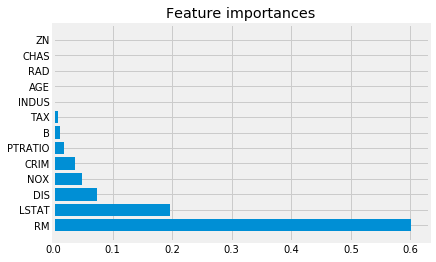

{'max_depth': 5, 'min_samples_split': 3}
1.814068514632643 0.8235966759074913


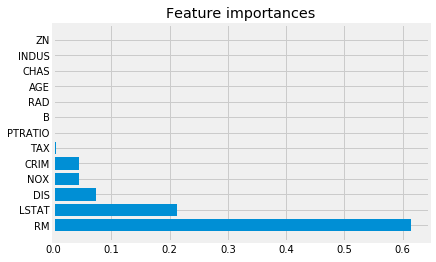

{'max_depth': 4, 'min_samples_split': 5}
2.3395312291382946 0.7291358471340089


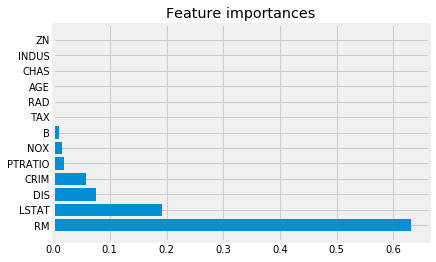

In [34]:
from sklearn.tree import DecisionTreeRegressor
params = [
    dict(max_depth=6, min_samples_split=5),
    dict(max_depth=5, min_samples_split=3),
    dict(max_depth=4, min_samples_split=5),
]

for i, p in enumerate(params):
    print(p)
    clf = DecisionTreeRegressor(**p)
    run(clf,p, run_name =  clf.__class__.__name__)

## MLFlow Project

To make the code above a MLFlow Project and use its remote-run functionality, we will first need to create a file named MLProject which speciefies the environment file as well as the entrypoint

In [35]:
%%writefile mlflow/MLProject
name: mlflow

conda_env: environment.yml

entry_points:
  main:
    parameters:
      alpha: float
      l1_ratio: {type: float, default: 0.1}
    command: "python train.py {alpha} {l1_ratio}"

Overwriting mlflow/MLProject


Also we will need to make a few adaptions to the code above:
 * import the utils functionalities
 * define a [main functionality](https://stackoverflow.com/questions/419163/what-does-if-name-main-do)
 * parse the command line arguments using sys

In [36]:
%%writefile mlflow/train.py
from utils import *
import git
def logMlflow(model,data,param=dict(),metrics=dict(),features=None, tags=dict(),run_name=None):
    # Imports
    import mlflow
    import os
    from sklearn.externals import joblib
    
    # Get some general information
    output_folder = "mlflow_out"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    type = model.__module__.split(".")[0]
    modelname = model.__class__.__name__
    
    # Start actual logging
    
    repo = git.Repo(search_parent_directories=True)
    sha = repo.head.object.hexsha
    mlflow.set_experiment(experiment_name="demo")
    if not run_name:
        run_name = modelname
    with mlflow.start_run(source_name=repo.remotes.origin.url,source_version=sha, run_name=run_name):
        
        # Log Parameters
        for k,v in param.items():
            mlflow.log_param(k, v)

        # Track dependencies
        import pkg_resources
        with open("{}/dependencies.txt".format(output_folder), "w+") as f: 
            for d in pkg_resources.working_set:
                f.write("{}={}\n".format(d.project_name,d.version))
        mlflow.log_artifact("{}/dependencies.txt".format(output_folder))
        
        # Track data
        data.to_csv("{}/data".format(output_folder))
        mlflow.log_artifact("{}/data".format(output_folder))
        
        if type=="sklearn":
            _ = joblib.dump(model,"{}/sklearn".format(output_folder))
            mlflow.log_artifact("{}/sklearn".format(output_folder))
        if type=="lgb":
            model.save_model("{}/lghtgbm.txt".format(output_folder))
            mlflow.log_artifact("{}/lghtgbm.txt".format(output_folder))
        
        # Log metrics
        for k,v in metrics.items():
            mlflow.log_metric(k,v)

        # plot Feature importances if avaible
        featurePlot = plotFeatureImportances(model, features, type)
        if featurePlot:
            mlflow.log_artifact("{}.png".format(featurePlot))
            
        # Set some tags to identify the experiment
        mlflow.set_tag("model",modelname)
        for tag, v in tags.items():
            mlflow.set_tag(t,v)
            
def run(clf, params, run_name=None):
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    metrics = eval_metrics(y_test, predictions)
    print(metrics['mae'], metrics['r2'])

    logMlflow(clf,data,param=params,metrics=metrics,features=x_test.columns.values, run_name=run_name)

if __name__ == "__main__":
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import ElasticNet
    import sys
    # Do a train_test_split
    data = getData()
    x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=10, random_state=42)
    
    params=dict(alpha=float(sys.argv[1]) if len(sys.argv) > 1 else 0.5,
                l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5)

    clf = ElasticNet(**params)

    run(clf,params)


Overwriting mlflow/train.py


Now you should be able to run this:

In [37]:
!mlflow run mlflow -P alpha=0.4

/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
=== Created directory /var/folders/yj/3mb90f8s26z19h634xqqcwzc0000gn/T/tmpdg2fmxyc for downloading remote URIs passed to arguments of type 'path' ===
=== Running command 'source activate mlflow-9287b7d0a49302fba1c4359778fab3153eb5bc8b && python train.py 0.4 0.1' in run with ID 'f6222416ab5346508c8651447de47644' === 
/Users/nkreiling/miniconda3/envs/mlflow-9287b7d0a49302fba1c4359778fab3153eb5bc8b/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
2.322056164683379 0.7251758570082479
=== Run (ID 'f6222416ab5346508c8651447de47644'

Or run it directly from our github account

In [38]:
!mlflow run mlflow -P alpha=0.4

/Users/nkreiling/miniconda3/envs/data-version-control/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
=== Created directory /var/folders/yj/3mb90f8s26z19h634xqqcwzc0000gn/T/tmpln4n5t03 for downloading remote URIs passed to arguments of type 'path' ===
=== Running command 'source activate mlflow-9287b7d0a49302fba1c4359778fab3153eb5bc8b && python train.py 0.4 0.1' in run with ID 'ecbaf2ec02104144b3d8bf81f4309948' === 
/Users/nkreiling/miniconda3/envs/mlflow-9287b7d0a49302fba1c4359778fab3153eb5bc8b/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
2.322056164683379 0.7251758570082479
=== Run (ID 'ecbaf2ec02104144b3d8bf81f4309948'